In [108]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from itertools import combinations
import utils
import modeling_utils
import joblib
from joblib import dump,load
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
pd.set_option('display.max_rows', 100)
pd.set_option('display.width',1000)
data=utils.get_data()
#label age and gender with numeric datatypes
#data=modeling_utils.age_gender_rename(data)
#data=modeling_utils.age_gender_rename(data)
#cap outliers
cap_dict={}#joblib.load('model_feature_ceilings.joblib')
#predict number of leads
lead_model_info=joblib.load('lead_prediction_model_info.joblib')
data=modeling_utils.make_predictions_pipeline(data,lead_model_info,cap_dict)
#predict approved conversions to sale
approved_conversion_model_info=joblib.load('approved_conversion_model_info.joblib')
data=modeling_utils.make_predictions_pipeline(data,approved_conversion_model_info,cap_dict)
#get 3 conversion classes based on age gender and interest, and CostPerMille. 
#These are observed 
data=modeling_utils.get_prob_class(data,'Approved_Conversion','Total_Conversion','Three_Conversion_Classes',3,'ObservedConvClass')
#these are predicted
#data=modeling_utils.add_conversion_rate_prediction(data) #an overfit model
data=modeling_utils.get_conversion_rate_preds(data)
data['Three_Conversion_Classes'].replace((0.0,0.33,0.67),('Low','Medium','High'),inplace=True)

In [109]:
df=pd.read_csv('campaign_c_facebook_ads.csv')

In [110]:
df.head()

,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,ClickThroughRate,ConversionRate,CostPerClick,CostPerConversion,Conversion_Value,ROAS,CostPerMille,RevenuePerMille,isFree,Free
0,campaign_c,3.0,2,10,1194718,141,254.049996,28,14,0.011802,0.500000,1.801773,18.146428,1400,5.510726,0.212644,1.171825,0,Paid
1,campaign_c,3.0,2,10,637648,67,122.400000,13,5,0.010507,0.384615,1.826866,24.480000,500,4.084967,0.191955,0.784132,0,Paid
2,campaign_c,3.0,2,10,24362,0,0.000000,1,1,0.000000,1.000000,0.000000,0.000000,100,0.000000,0.000000,4.104753,1,Free
3,campaign_c,3.0,2,10,459690,50,86.330001,5,2,0.010877,0.400000,1.726600,43.165001,200,2.316692,0.187800,0.435076,0,Paid
4,campaign_c,3.0,2,10,750060,86,161.909999,11,2,0.011466,0.181818,1.882674,80.955000,200,1.235254,0.215863,0.266645,0,Paid


<Figure size 1000x1000 with 0 Axes>

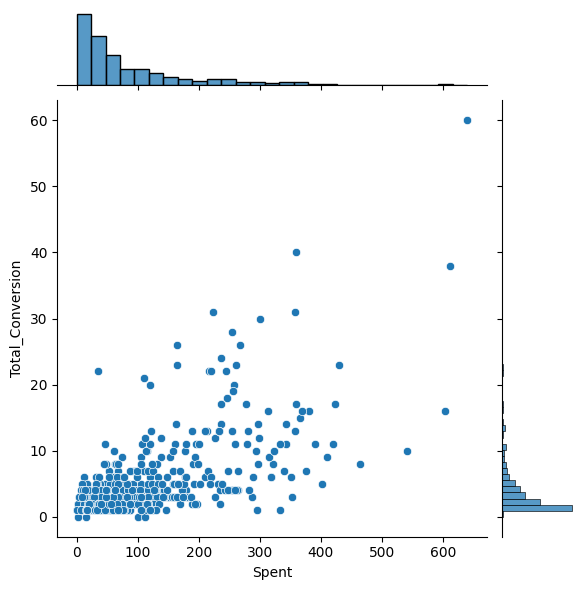

In [111]:
plt.figure(figsize=(10,10))
sns.jointplot(data=df,x='Spent',y='Total_Conversion')
plt.grid(which='minor')
plt.show()

<Figure size 1000x1000 with 0 Axes>

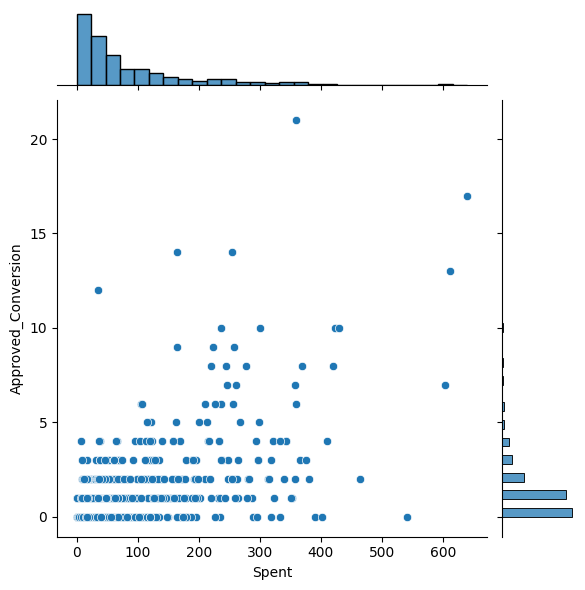

In [112]:
plt.figure(figsize=(10,10))
sns.jointplot(data=df,x='Spent',y='Approved_Conversion')
plt.grid(which='minor')
plt.show()

In [113]:
mddf=df.copy()


In [114]:

def capvals(data,caps):
    for key,val in caps.items():
        data=data.loc[data[key]<val]
    return data

In [125]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures


def get_linear(X_cap,y_cap,X_uncap,y_uncap):
    
    scal=StandardScaler()
    res={}
    res['alphas']=[]
    res['degrees']=[]
    res['r2s']=[]
    res['mae']=[]
    for deg in range(1,5):
        """
        res['alphas'].append('#--#')
        res['degrees'].append('#--#')
        res['r2s'].append('#--#')
        res['mae'].append('#--#')
        """
        
        X_capped=X_cap.copy()
        X_uncapped=X_uncap.copy()
        y_capped=y_cap.copy()
        y_uncapped=y_uncap.copy()
        poly=PolynomialFeatures(degree=deg)
        X_capped=poly.fit_transform(X_capped)
        X_capped=scal.fit_transform(X_capped)
        X_uncapped=poly.transform(X_uncapped)
        X_uncapped=scal.transform(X_uncapped)
        for a in np.linspace(0,3,15):
            mod=Lasso(alpha=a)
            mod.fit(X_capped,y_capped)
            y_pred_uncapped=mod.predict(X_uncapped)
            r2=r2_score(y_uncapped,y_pred_uncapped)
            mae=mean_absolute_error(y_uncapped,y_pred_uncapped)
            if r2>0.7:
                res['alphas'].append(a)
                res['degrees'].append(deg)
                res['r2s'].append(r2)
                res['mae'].append(mae)
    return pd.DataFrame(res)



In [126]:
caps={'Spent':125,'Total_Conversion':7,'Approved_Conversion':4}
mddf=df.copy()
mddf=capvals(mddf,caps)
X=['age','gender','interest','Spent']
y='Total_Conversion'
get_linear(mddf[X],mddf[y],df[X],df[y])

,alphas,degrees,r2s,mae


In [ ]:

import warnings
warnings.filterwarnings('ignore')
X=['age','gender','interest','Spent']
y='Total_Conversion'
df1=df.copy()
df1=df1.sample(frac=1)
df1=df1.reset_index(drop=True)


#for spnt in list(range(100,401,25))+[float('inf')]:
    for tcnv in list(range(6,11))+[float('inf')]:
        for acnv in list(range(3,6))+[float('inf')]:
            caps={'Spent':spnt,'Total_Conversion':tcnv,'Approved_Conversion':acnv}
            df2=df1.copy()
            mddf=df1.copy()
            mddf=capvals(mddf,caps)
            split=(df2.shape[0]//3)*2
            mddf=mddf.iloc[:split,:]
            df2=df2.iloc[split:,:]
            
            fr=get_linear(mddf[X],mddf[y],df2[X],df2[y])
            if fr.shape[0]>0:
                print(f'spend: {spnt}\ntotal conversions: {tcnv}\napproved conversions: {acnv}')
                display(fr)

In [ ]:
spend: 375
total conversions: inf
approved conversions: inf
alphas	degrees	r2s	mae
0	0.000000	2	0.827635	1.873673
1	0.000000	3	0.839167	1.808725
2	0.214286	4	0.711472	2.243278

In [129]:
from sklearn.pipeline import make_pipeline

pipe=make_pipeline(PolynomialFeatures(degree=3),StandardScaler(),Lasso())

In [132]:
from sklearn.model_selection import train_test_split
dff=df.copy()
dff=dff.loc[dff['Spent']<=375]

X=dff[['age','gender','interest','Spent']]
y=dff['Approved_Conversion']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.33,random_state=43)
print(f'There are {dff.shape[0]} rows in the data')

There are 612 rows in the data


In [136]:
pipe.fit(X_train,y_train)
#save this

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [ ]:
########SAVE THE TRAIN AND TEST DATA TO THE FILE

In [ ]:
def get_r2_mae(model,X_set,y_set):
    """
    get_r2_mae(model,X_set,y_set)
    returns r2,mae
    """
    pred=model.predict(X_set)
    r2=r2_score(y_set,pred)
    mae=mean_absolute_error(y_set,pred)
    return r2,mae

def get_subsets(testX, testy, num_subsets=4):
    """
    get_subsets(testX, testy, num_subsets=4)
    returns 2 dictionaries -> X_subsets and y_subsets
    dictionaries are keyed 1 to n slices
    slices are sized within 1 row difference between any other
    """

    top_val = testX.shape[0]
    borders = [int(i) if i!=top_val else int(i+1) for i in np.linspace(0, testX.shape[0], num_subsets + 1)]
    X_subsets = {}
    y_subsets = {}
    for i in range(len(borders) - 1):
        X_subsets[i + 1] = testX[borders[i]:borders[i + 1]]
        y_subsets[i + 1] = testy[borders[i]:borders[i + 1]]
    return X_subsets, y_subsets


def get_slice_scores(model,X_subsets,y_subsets):
    """
    get_slice_scores(model,X_subsets,y_subsets)
    where X and y subsets are the result of func: get_subsets(testX, testy, num_subsets=4)
    uses func: get_r2_mae(model,X_set,y_set) to calculate scores
    returns a dataframe of r2 and mae scores for each subset
    """
    info={'data_slice':[],'r2':[],'mae':[]}
    for key in X_subsets.keys():
        info['data_slice'].append(key)
        r2,mae=get_r2_mae(model,X_subsets[key],y_subsets[key])
        info['r2'].append(r2)
        info['mae'].append(mae)
    return pd.DataFrame(info)

    

In [ ]:
def get_train_test_preds(model,X_train,X_test,y_train,y_test):
    test_r2,test_mae=get_r2_mae(model,X_train,y_train)
    train_r2,train_mae=get_r2_mae(model,X_test,y_test)
    return pd.DataFrame({'Score':['R2','MAE'],'test':[test_r2,test_mae],'train':[train_r2,train_mae]})